In [1]:
#Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader



In [3]:
# Create a small synthetic dataset with white noise and square labeled masks
def create_synthetic_dataset(num_samples=100, image_size=(100, 100), particle_size=10, noise_level=0.2):
    dataset = []

    for _ in range(num_samples):
        image = noise_level * torch.randn(1, *image_size)
        x, y = np.random.randint(0, image_size[0] - particle_size), np.random.randint(0, image_size[1] - particle_size)
        image[ 0, x:x + particle_size, y:y + particle_size] = 1.0

        #save the mask as label
        label = torch.zeros(1, *image_size)
        label[0, x:x + particle_size, y:y + particle_size] = 1.0
        
        

        dataset.append((image, label))

    return dataset



In [2]:
# Create synthetic data that emulates the real data (Joachim's code)
#Created directly in torch
def gaussian(pos, mu, params):
    x, y = pos
    x0, y0 = mu
    A, sigma = params
    return A * torch.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

def generate_images(num_images, x_dim, y_dim, num_gaussians=100, gauss_params=(1, 1), noise_stddev=0.1):
    dataset = []
    images = []
    positions_list = []
    gauss_masks = []
    for _ in range(num_images):
        sim_domain = torch.zeros((x_dim, y_dim))
        positions = torch.zeros((2, num_gaussians))
        positions[0, :] = torch.randint(0, x_dim, (num_gaussians,))
        positions[1, :] = torch.randint(0, y_dim, (num_gaussians,))
        x = torch.arange(x_dim)
        y = torch.arange(y_dim)
        x, y = torch.meshgrid(x, y)

        for n in range(num_gaussians):
            sim_domain += gaussian((x, y), positions[:, n], gauss_params).t()

        # Store the images and masks as tensors with 1 channel
        noise = torch.normal(mean=0., std=noise_stddev, size=sim_domain.shape)
        



        # Store the images and masks as tensors with 1 channel
        dataset.append((sim_domain.unsqueeze(0) + 1.9*noise,sim_domain.unsqueeze(0)))

    return dataset

c:\Users\farim\anaconda3\envs\02463\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\farim\AppData\Local\Temp\ipykernel_21160\3217701344.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


torch.Size([1, 100, 100])
tensor(1.7643)
tensor(-0.7931)


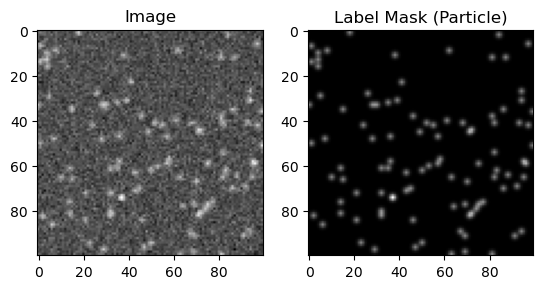

In [3]:
# Visualize an image and its corresponding label mask
def visualize_image(image, label):
    plt.figure()
    plt.title("Particle Detection")
    plt.subplot(1, 2, 1)
    plt.imshow(image[0].numpy(), cmap='gray')
    plt.title("Image")
    plt.subplot(1, 2, 2)
    plt.imshow(label[0].numpy(), cmap='gray')
    plt.title("Label Mask (Particle)")

# Create and visualize the dataset
#dataset = create_synthetic_dataset(num_samples=2)
dataset = generate_images(2, 100, 100)
image, label = dataset[0]
visualize_image(image, label)
# print the type of dataset
print(dataset[0][1].shape)
#print the range of values in the image
print(torch.max(dataset[0][0]))
print(torch.min(dataset[0][0]))

plt.show()

In [7]:
#Define UNet model architecture

class ParticleDetectionUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=64):
        super(ParticleDetectionUNet, self).__init__()
        
        # Encoder (downsampling)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features, features * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(features * 2, features * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoder (upsampling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, out_channels, kernel_size=1)  # Output layer
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)
        
        # Bottleneck
        x2 = self.bottleneck(x1)
        
        # Decoder
        x3 = self.decoder(x2)
        
        return x3

# Instantiate the model
model = ParticleDetectionUNet()




Epoch 1/1, Train Step 1/30, Loss: 0.7523
Images shape: torch.Size([10, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.7441
Epoch 1/1, Train Step 2/30, Loss: 0.7441
Images shape: torch.Size([10, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.7296
Epoch 1/1, Train Step 3/30, Loss: 0.7296
Images shape: torch.Size([10, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.7038
Epoch 1/1, Train Step 4/30, Loss: 0.7038
Images shape: torch.Size([10, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.6485
Epoch 1/1, Train Step 5/30, Loss: 0.6484
Images shape: torch.Size([10, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.5511
Epoch 1/1, Train Step 6/30, Loss: 0.5509
Images shape: torch.Size([10, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.4044
Epoch 1/1, Train Step 7/30, Loss: 0.4044
Images shape: torch.Size([10, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.2381
Epoch 1/1, Train Step 8/30, Loss: 0.2385
Images shape: torch.Size([10, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.1189
Epoch 1/1, Train Step 9/30, Loss: 0.1193

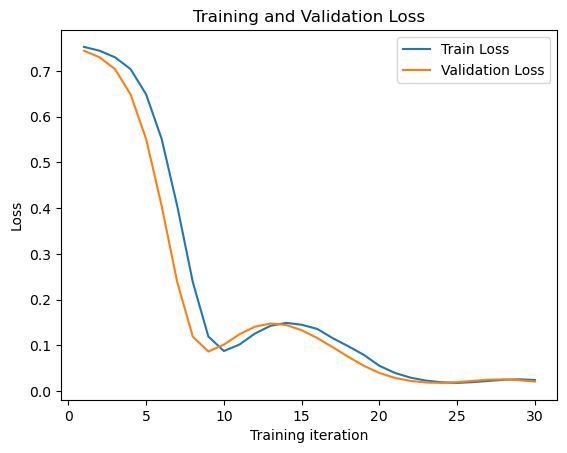

In [83]:
#Train the model with first type of data and plot the training and validation loss

# Define the model, loss function, and optimizer
model = ParticleDetectionUNet()
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load the synthetic training dataset
train_dataset = create_synthetic_dataset(num_samples=300)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

# Load a separate validation dataset
validation_dataset = create_synthetic_dataset(num_samples=20)  # Adjust the size as needed
validation_loader = DataLoader(validation_dataset, batch_size=20)

# Training and validation loop
num_epochs = 1

train_loss_history = []  # Store training loss
validation_loss_history = []  # Store validation loss

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Step {i + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")
    
        print(f"Images shape: {images.shape}")

        # Validation loop
        model.eval()  # Set the model to evaluation mode

        with torch.no_grad():
            validation_loss = 0.0
            for j, (val_images, val_labels) in enumerate(validation_loader):
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                validation_loss += val_loss.item()
            
            avg_validation_loss = validation_loss / len(validation_loader)
            print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_validation_loss:.4f}")

        train_loss_history.append(loss.item())
        validation_loss_history.append(avg_validation_loss)

    print(f"Epoch {epoch + 1}/{num_epochs} done!")

# Plot the training and validation loss history
plt.figure()
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train Loss')
plt.plot(range(1,len(validation_loss_history) + 1), validation_loss_history, label='Validation Loss')
plt.xlabel('Training iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


Input Image range: (-0.8096553087234497, 1.0)
Output range: (-7.102828502655029, 0.1165953278541565)
Label range: (0.0, 1.0)


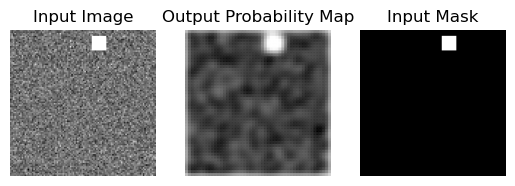

In [100]:
#Test the model on a sample image
sample_image = create_synthetic_dataset(num_samples=1)[0]
#visualize output for a sample image
model.eval()
with torch.no_grad():
    output = model(sample_image[0].unsqueeze(0))

#Print range of sample image, output and mask
print(f"Input Image range: ({torch.min(sample_image[0])}, {torch.max(sample_image[0])})")
print(f"Output range: ({torch.min(output)}, {torch.max(output)})")
print(f"Label range: ({torch.min(sample_image[1])}, {torch.max(sample_image[1])})")


# Visualize the output along with the input image and mask
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(sample_image[0][0].numpy(), cmap='gray')
plt.title("Input Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(output[0][0].numpy(), cmap='gray')
plt.title("Output Probability Map")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(sample_image[1][0].numpy(), cmap='gray')
plt.title("Input Mask")
plt.axis('off')
plt.show()


In [9]:
#Generate data
train_dataset = generate_images(1000, 100, 100)
validation_dataset = generate_images(20, 100, 100)

Epoch 1/1, Train Step 1/160, Loss: 0.6862
Images shape: torch.Size([25, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.6699
Epoch 1/1, Train Step 2/160, Loss: 0.6699
Images shape: torch.Size([25, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.6432
Epoch 1/1, Train Step 3/160, Loss: 0.6433
Images shape: torch.Size([25, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.5907
Epoch 1/1, Train Step 4/160, Loss: 0.5907
Images shape: torch.Size([25, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.4974
Epoch 1/1, Train Step 5/160, Loss: 0.4975
Images shape: torch.Size([25, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.3721
Epoch 1/1, Train Step 6/160, Loss: 0.3725
Images shape: torch.Size([25, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.2771
Epoch 1/1, Train Step 7/160, Loss: 0.2774
Images shape: torch.Size([25, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.2903
Epoch 1/1, Train Step 8/160, Loss: 0.2930
Images shape: torch.Size([25, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.3455
Epoch 1/1, Train Step 9/160, Los

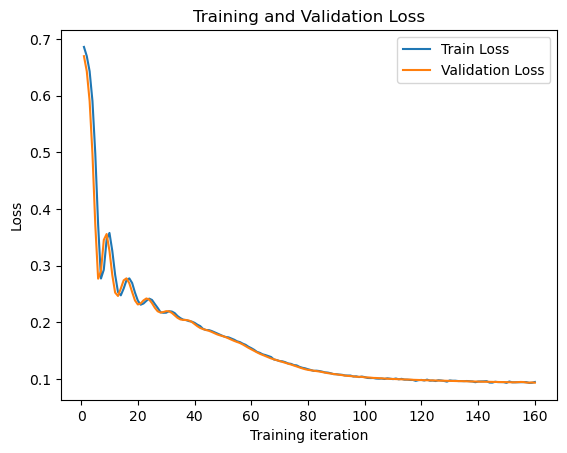

In [132]:
#Train the model the data emulating the real data and plot the training and validation loss

# Define the model, loss function, and optimizer
model = ParticleDetectionUNet()
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load the synthetic training dataset
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

# Load a separate validation dataset
validation_loader = DataLoader(validation_dataset, batch_size=20)

# Training and validation loop
num_epochs = 1

train_loss_history = []  # Store training loss
validation_loss_history = []  # Store validation loss

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Step {i + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")
    
        print(f"Images shape: {images.shape}")

        # Validation loop
        model.eval()  # Set the model to evaluation mode

        with torch.no_grad():
            validation_loss = 0.0
            for j, (val_images, val_labels) in enumerate(validation_loader):
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                validation_loss += val_loss.item()
            
            avg_validation_loss = validation_loss / len(validation_loader)
            print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_validation_loss:.4f}")

        train_loss_history.append(loss.item())
        validation_loss_history.append(avg_validation_loss)

    print(f"Epoch {epoch + 1}/{num_epochs} done!")

# Plot the training and validation loss history
plt.figure()
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train Loss')
plt.plot(range(1,len(validation_loss_history) + 1), validation_loss_history, label='Validation Loss')
plt.xlabel('Training iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


Input Image range: (-0.7456300854682922, 1.72017502784729)
Output range: (-12.575713157653809, 7.712697982788086)
Label range: (0.0, 1.6065306663513184)


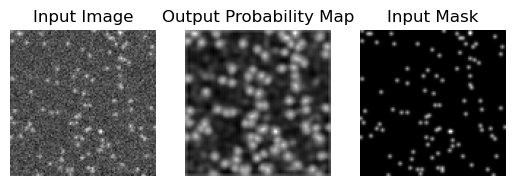

In [138]:
#Test the model on a sample image
sample_image = generate_images(1, 100, 100)[0]
#visualize output for a sample image
model.eval()
with torch.no_grad():
    output = model(sample_image[0].unsqueeze(0))

#Print range of sample image, output and mask
print(f"Input Image range: ({torch.min(sample_image[0])}, {torch.max(sample_image[0])})")
print(f"Output range: ({torch.min(output)}, {torch.max(output)})")
print(f"Label range: ({torch.min(sample_image[1])}, {torch.max(sample_image[1])})")


# Visualize the output along with the input image and mask
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(sample_image[0][0].numpy(), cmap='gray')
plt.title("Input Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(output[0][0].numpy(), cmap='gray')
plt.title("Output Probability Map")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(sample_image[1][0].numpy(), cmap='gray')
plt.title("Input Mask")
plt.axis('off')
plt.show()


In [18]:
"""
This is not done yet. I think it is right up until the point where we need to pass the output of the UNet to the LSTM.
"""
#Making a new model combining UNet and LSTM
class ParticleDetectionModel(nn.Module):
    def __init__(self, input_channels=1, num_classes=1, num_filters=64):
        super(ParticleDetectionModel, self).__init__()
        
        # U-Net Architecture for Frame-Level Detection
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, num_filters, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.middle = nn.Sequential(
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(num_filters, num_filters, kernel_size=2, stride=2),
            nn.ConvTranspose2d(num_filters, num_filters, kernel_size=2, stride=2),
            nn.Conv2d(num_filters, num_classes, kernel_size=1)
        )
        
        # Bidirectional LSTM for Temporal Consistency
        self.lstm = nn.LSTM(input_size=num_classes, hidden_size=num_classes, num_layers=2, batch_first=True, bidirectional=True)
        
    def forward(self, frames):
        # U-Net Forward Pass
        features = []
        for frame in frames:
            x = self.encoder(frame)
            x = self.middle(x)
            x = self.decoder(x)
            features.append(x)
        

        # Concatenate the features from all frames
        x = torch.cat(features, dim=1)

        # Reshape the features to match LSTM input dimensions
        #batch_size, num_channels, H, W = x.size()
        #x = x.view(batch_size, -1, num_channels * H * W)


        # Bidirectional LSTM Forward Pass
        #lstm_out, _ = self.lstm(x)

    
        
        # Output: Probability Maps for Each Frame
        #probability_maps = torch.sigmoid(lstm_out)
        
        #return lstm_out

        return x
        #return probability_maps


In [1]:
# Create a dummy input tensor
# Assuming your input is a sequence of 10 grayscale images of size 64x64
dummy_input = torch.randn(1, 10, 1, 64, 64)  # (batch_size, sequence_length, channels, height, width)

model_unet_lstm = ParticleDetectionModel()

# Pass the dummy input through the model
output = model_unet_lstm(dummy_input)

print(output.shape)

NameError: name 'torch' is not defined

In [12]:
class ParticleDetectionUNetIte2(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=64):
        super(ParticleDetectionUNetIte2, self).__init__()
        
        # Encoder (downsampling)
    
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features, features * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(features * 2, features * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoder (upsampling)
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(features * 2, features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, out_channels, kernel_size=1)  # Output layer
        )

    def forward(self, x):
        # Encoder
        x1 = self.conv1(x)
        x2 = self.pool1(x1)
        
        # Bottleneck
        x3 = self.bottleneck(x2)
        
        # Decoder
        x4 = self.upconv1(x3)
        x5 = torch.cat([x4, x1], dim=1)  # Skip connection
        x6 = self.conv2(x5)
        
        return x6


Epoch 1/1, Train Step 1/20, Loss: 0.6831
Images shape: torch.Size([50, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.6768
Epoch 1/1, Train Step 2/20, Loss: 0.6768
Images shape: torch.Size([50, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.5910
Epoch 1/1, Train Step 3/20, Loss: 0.5909
Images shape: torch.Size([50, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.4384
Epoch 1/1, Train Step 4/20, Loss: 0.4385
Images shape: torch.Size([50, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.2690
Epoch 1/1, Train Step 5/20, Loss: 0.2690
Images shape: torch.Size([50, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.3133
Epoch 1/1, Train Step 6/20, Loss: 0.3148
Images shape: torch.Size([50, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.3606
Epoch 1/1, Train Step 7/20, Loss: 0.3600
Images shape: torch.Size([50, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.3122
Epoch 1/1, Train Step 8/20, Loss: 0.3136
Images shape: torch.Size([50, 1, 100, 100])
Epoch 1/1, Validation Loss: 0.2492
Epoch 1/1, Train Step 9/20, Loss: 0.2500

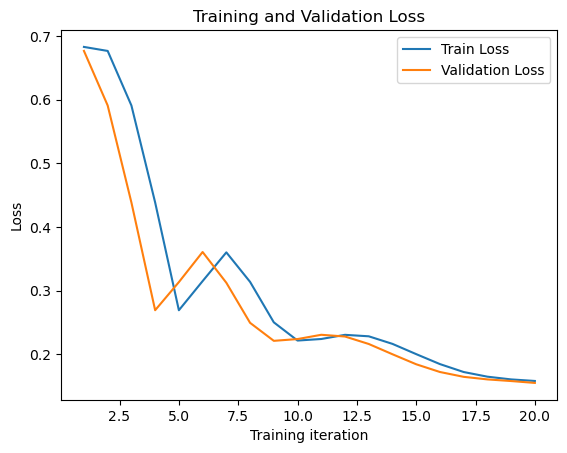

In [13]:
#Train the model the data emulating the real data and plot the training and validation loss

# Define the model, loss function, and optimizer
model = ParticleDetectionUNetIte2()
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load the synthetic training dataset
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

# Load a separate validation dataset
validation_loader = DataLoader(validation_dataset, batch_size=20)

# Training and validation loop
num_epochs = 1

train_loss_history = []  # Store training loss
validation_loss_history = []  # Store validation loss

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Step {i + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")
    
        print(f"Images shape: {images.shape}")

        # Validation loop
        model.eval()  # Set the model to evaluation mode

        with torch.no_grad():
            validation_loss = 0.0
            for j, (val_images, val_labels) in enumerate(validation_loader):
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                validation_loss += val_loss.item()
            
            avg_validation_loss = validation_loss / len(validation_loader)
            print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_validation_loss:.4f}")

        train_loss_history.append(loss.item())
        validation_loss_history.append(avg_validation_loss)

    print(f"Epoch {epoch + 1}/{num_epochs} done!")

# Plot the training and validation loss history
plt.figure()
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train Loss')
plt.plot(range(1,len(validation_loss_history) + 1), validation_loss_history, label='Validation Loss')
plt.xlabel('Training iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


Input Image range: (-0.8182787299156189, 1.8874475955963135)
Output range: (-6.976637840270996, -0.5761749744415283)
Label range: (0.0, 1.6886156797409058)


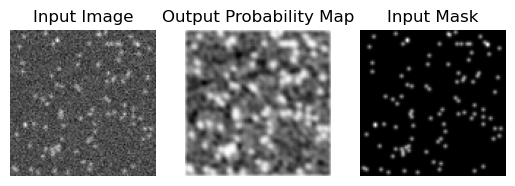

In [20]:
#Test the model on a sample image
sample_image = generate_images(1, 100, 100)[0]
#visualize output for a sample image
model.eval()
with torch.no_grad():
    output = model(sample_image[0].unsqueeze(0))

#Print range of sample image, output and mask
print(f"Input Image range: ({torch.min(sample_image[0])}, {torch.max(sample_image[0])})")
print(f"Output range: ({torch.min(output)}, {torch.max(output)})")
print(f"Label range: ({torch.min(sample_image[1])}, {torch.max(sample_image[1])})")


# Visualize the output along with the input image and mask
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(sample_image[0][0].numpy(), cmap='gray')
plt.title("Input Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(output[0][0].numpy(), cmap='gray')
plt.title("Output Probability Map")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(sample_image[1][0].numpy(), cmap='gray')
plt.title("Input Mask")
plt.axis('off')
plt.show()
